Assuming cache file is valid
[2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5]



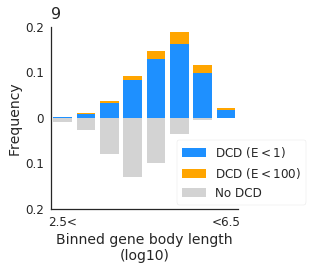

In [2]:
%matplotlib inline

import os as os
import collections as col
import itertools as itt
import pickle as pck
import json as js
import time as ti

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import numpy.random as rng
import scipy.stats as stats
import pandas as pd
import seaborn as sns

# What does this do?
# Plot boxplots of HSP/gene
# overlaps relating DE gene length
# and HSP expect

date = '20180801'

run_plot_hsp100_gene_ovl = True

save_figures = True
diss_version = False

journal = 'bmc_genbio'
res = 'print_lo'
fig_sizes = js.load(open('/home/pebert/work/code/mpggit/statediff/annotation/misc/fig_sizes.json'))
fig_sizes = fig_sizes[journal]
resolution = fig_sizes['resolution']

sns.set(style='white',
        font_scale=1.5,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis/projects/statediff'
cache_dir = os.path.join(fhgfs_base, 'caching/notebooks')

segmentations = ['cmm18', 'ecs18', 'ecs10']
scorings = ['penem', 'ordem', 'penrep', 'ordrep']

hsp_gene_ovl_folder = os.path.join(fhgfs_base, 'bedtools/deep/isect_gene_hsp100')

de_gene_folder = os.path.join(fhgfs_base, 'deseq/deep')
bed_gene_folder = os.path.join(fhgfs_base, 'deseq/bed_out')

base_out = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/statediff'
fig_supp = os.path.join(base_out, 'figures', 'pub', 'supp')
fig_main = os.path.join(base_out, 'figures', 'pub', 'main')
fig_collect = os.path.join(base_out, 'figures', 'pub', 'collection')
fig_diss = '/home/pebert/work/code/mpggit/dissertation/Figures/diffchrom'
                   

def get_table_header():
    
    hsp_header = ['chrom', 'start', 'end', 'name', 'nat_score',
                  'expect', 'segment_pv', 'nat_score_lnorm', 'group1', 'group2']
    
    hsp_header = ['hsp_' + h for h in hsp_header]
    
    gene_header = "chrom  start   end name    log2fc  strand  symbol  pv_adj baseMean is_de".split()
    gene_header = ['gene_' + h for h in gene_header]
    
    table_header = gene_header + hsp_header + ['overlap']
    
    return table_header
    
    
def cache_gene_ovl_data(rootfolder, cache_file):
    """
    """   
    table_header = get_table_header()
    
    for tsv in os.listdir(rootfolder):
        if not tsv.endswith('.tsv'):
            continue
        fpath = os.path.join(rootfolder, tsv)
        # deep_hsp_ovl_degenes_cmm18_HG_vs_He_emission.tsv
        infos = tsv.split('.')[0].split('_')
        seg, scoring = infos[3], infos[-1]
        comp = '_'.join(infos[4:7])
        
        df = pd.read_csv(fpath, sep='\t', names=table_header, skiprows=1)
        df['overlap'] = df['overlap'].astype(np.int32)
        df['gene_is_hit'] = np.array(df['overlap'] > 0, dtype=np.int8)
        df = df.loc[:, ['hsp_expect', 'gene_is_de', 'gene_name',
                        'gene_start', 'gene_end', 'gene_is_hit']].copy()
        df['gene_is_de'] = df['gene_is_de'].astype(np.int8)
        df = df.loc[df['gene_is_de'] == 1, :]
        df.drop_duplicates(inplace=True)
        df.loc[df['hsp_expect'] == '.', 'hsp_expect'] = -1
        df['hsp_expect'] = df['hsp_expect'].astype(np.float32)
        df['gene_length'] = df['gene_end'] - df['gene_start']
                
        cache_path = os.path.join(seg, scoring, comp)
        with pd.HDFStore(cache_file, 'a') as hdf:
            hdf.put(cache_path, df, format='fixed')

    return cache_file
    

def create_histogram(plot_data, fkey, save_diss):
    """
    """  
    fig, ax = plt.subplots(figsize=fig_sizes['one_col']['square'],
                           nrows=1, ncols=1,
                           sharex=True, sharey=True)

    log_length = np.log10(plot_data['gene_length'])
    plot_data['loglen'] = log_length
    lower_bound = log_length.min() // 0.5 * 0.5
    upper_bound = log_length.max() // 0.5 * 0.5 + 0.5
    
    length_bins = np.arange(lower_bound, upper_bound + 0.5, 0.5)
    print(length_bins)
    plot_data['bin'] = np.digitize(plot_data['loglen'],
                                   length_bins,
                                   right=False)
    bin_numbers = sorted(plot_data['bin'].unique())
    
    assert length_bins[0] <= log_length.min(), 'Minimum out of bounds: {} / {}'.format(log_length.min(),
                                                                                       length_bins[0])
    assert log_length.max() < length_bins[-1], 'Maximum out of bounds: {} / {}'.format(log_length.max(),
                                                                                       length_bins[-1])
        
    total_hsps = plot_data.shape[0]
    
    nosig_group = plot_data.loc[plot_data['hsp_expect'] >= 1, :].copy()
    none_group = plot_data.loc[plot_data['hsp_expect'] == -1, :].copy()
    sig_select = np.logical_and(plot_data['hsp_expect'] < 1,
                                plot_data['hsp_expect'] > -1)
    sig_group = plot_data.loc[sig_select, :].copy()
    
    assert nosig_group.shape[0] + none_group.shape[0] + sig_group.shape[0] == total_hsps, 'Missed'
    
    nosig_counts = sorted(col.Counter(nosig_group['bin']).items())
    nosig_freq = np.array([c for b,c in nosig_counts], dtype=np.float16) / total_hsps
    sig_counts = sorted(col.Counter(sig_group['bin']).items())
    sig_freq = np.array([c for b,c in sig_counts], dtype=np.float16) / total_hsps
    none_counts = sorted(col.Counter(none_group['bin']).items())
    none_freq = np.array([c for b,c in none_counts], dtype=np.float16) / total_hsps
    none_freq *= -1
    
    ax.set_xlim(bin_numbers[0] - 0.5, bin_numbers[-1] + 0.5)
    print()
    ax.set_ylim(-0.2, 0.2)
    
    sig_bars = ax.bar(bin_numbers, sig_freq,
                      color='dodgerblue',
                      label='DCD (E$<$1)')
    
    nosig_bars = ax.bar(bin_numbers, nosig_freq,
                        color='orange', bottom=sig_freq,
                        label='DCD (E$<$100)')
    
    none_bars = ax.bar(bin_numbers, none_freq,
                       color='lightgrey',
                       label='No DCD')

    x_ticks = [1, 8]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(['2.5<', '<6.5'], fontsize=12)
    ax.set_yticklabels(['0.2', '0.1', '0', '0.1', '0.2'], fontsize=12)
    
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_xlabel('Binned gene body length\n(log10)', fontsize=14)
            
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    leg = ax.legend(loc='right', fontsize=12, ncol=1,
                    bbox_to_anchor=(1.4, 0.2), frameon=True)
    
    if not save_diss:
        tt = ax.set_title(fkey, fontsize=16)
        tt.set_position((0.025, 1.01))
                    
    
    return fig, []

            
def plot_hsp100_gene_ovl():
    cache_file = os.path.join(cache_dir, '{}_plot_hsp-t100_gene_ovl.h5'.format(date))
    if not os.path.isfile(cache_file):
        _ = cache_gene_ovl_data(hsp_gene_ovl_folder, cache_file)
    elif os.stat(cache_file).st_size < 1e4:
        print('Assuming cache file corrupted')
        _ = cache_gene_ovl_data(hsp_gene_ovl_folder, cache_file)
    else:
        print('Assuming cache file is valid')
    
    with pd.HDFStore(cache_file, 'r') as hdf:
        cached_keys = list(hdf.keys())

        for seg in segmentations:
            if seg != 'cmm18':
                continue
            for scoring in scorings:
                if scoring != 'penem':
                    continue
                load_keys = [k for k in cached_keys if seg in k and scoring in k]
                
                plot_data = []
                for k in load_keys:
                    if 'Liver' in k:
                        continue
                    plot_data.append(hdf[k])
                plot_data = pd.concat(plot_data, axis=0, ignore_index=False)
                
                fk = '9'
                fig, exart = create_histogram(plot_data, fk, diss_version)
                if save_figures:
                    outname = 'fig_{}_hsp-t100-DEG_{}_{}'.format(fk, seg, scoring)
                    outfolder = fig_main
                    if diss_version:
                        outfolder = fig_diss
                    
                    out_pdf = os.path.join(outfolder, outname + '.pdf')
                    fig.savefig(out_pdf, bbox_inches='tight', extra_artists=exart)
                    
                    if not diss_version:
                        out_png = os.path.join(outfolder, outname + '.png')
                        fig.savefig(out_png, bbox_inches='tight', extra_artists=exart, dpi=resolution[res])
                                
    return 0

    
if run_plot_hsp100_gene_ovl:
    plot_hsp100_gene_ovl()
